# HDF5 dataset exploration and explanation

This notebook explains the structure of the IAM word-level HDF5 files used by the project (e.g. `iam/trnvalset_words64_OrgSz.hdf5`, `iam/testset_words64_OrgSz.hdf5`).
It inspects the file contents, prints shapes/dtypes, shows how to reconstruct individual word images and labels, and documents how the training dataloader consumes these arrays.

In [16]:
# Standard imports for inspection and visualization
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Path to the example HDF5 file (relative to repo root)
h5_path = 'data/iam/testset_words64_OrgSz.hdf5'
h5_path2 = 'data/iam/trnvalset_words64_OrgSz.hdf5'
print('HDF5 path ->', h5_path)

HDF5 path -> data/iam/testset_words64_OrgSz.hdf5


In [17]:
import os
import h5py
import numpy as np

def summarize_h5(path):
    if not os.path.exists(path):
        print(f"{path} does not exist in this environment.")
        return
    
    with h5py.File(path, 'r') as f:
        print('Keys:', list(f.keys()))
        for k in f.keys():
            dset = f[k]
            try:
                shape = dset.shape
            except Exception:
                shape = 'unknown'
            
            # Attempt to print the length of the dataset (if applicable)
            try:
                length = len(dset)
            except TypeError:
                length = 'N/A'
            
            print(f'--- {k}: shape={shape}, dtype={dset.dtype}, len={length}')
        
        # Helpful summaries for expected keys
        if 'imgs' in f:
            imgs = f['imgs'][:]
            print('\nimgs summary:')
            print(f'  dtype={imgs.dtype}, min={imgs.min()}, max={imgs.max()}')
            print('  expected shape: (ImgHeight, total_concat_width) e.g. (64, W_total)')
        
        if 'lbs' in f:
            lbs = f['lbs'][:]
            print('\nlbs summary:')
            print(f'  dtype={lbs.dtype}, sample values (first 20)={lbs[:20]}')
        
        if 'img_lens' in f:
            print(f'\nimg_lens: number of word images = {len(f["img_lens"])}')
    
        if 'wids' in f:
            wids = f['wids'][:]
            print(f'wids (writer ids) range = {np.min(wids)} -> {np.max(wids)}')
            
summarize_h5(h5_path)

Keys: ['img_lens', 'img_seek_idxs', 'imgs', 'lb_lens', 'lb_seek_idxs', 'lbs', 'wids']
--- img_lens: shape=(11170,), dtype=int16, len=11170
--- img_seek_idxs: shape=(11170,), dtype=int64, len=11170
--- imgs: shape=(64, 1709783), dtype=uint8, len=64
--- lb_lens: shape=(11170,), dtype=int16, len=11170
--- lb_seek_idxs: shape=(11170,), dtype=int64, len=11170
--- lbs: shape=(49638,), dtype=int32, len=49638
--- wids: shape=(11170,), dtype=int16, len=11170

imgs summary:
  dtype=uint8, min=0, max=243
  expected shape: (ImgHeight, total_concat_width) e.g. (64, W_total)

lbs summary:
  dtype=int32, sample values (first 20)=[ 98 101 110  99 104 102 114 111 109 104 105 115 114 111 115 101  72 101
  98 114]

img_lens: number of word images = 11170
wids (writer ids) range = 372 -> 499


In [18]:
summarize_h5(h5_path2)


Keys: ['img_lens', 'img_seek_idxs', 'imgs', 'lb_lens', 'lb_seek_idxs', 'lbs', 'wids']
--- img_lens: shape=(52231,), dtype=int16, len=52231
--- img_seek_idxs: shape=(52231,), dtype=int64, len=52231
--- imgs: shape=(64, 8139273), dtype=uint8, len=64
--- lb_lens: shape=(52231,), dtype=int16, len=52231
--- lb_seek_idxs: shape=(52231,), dtype=int64, len=52231
--- lbs: shape=(248557,), dtype=int32, len=248557
--- wids: shape=(52231,), dtype=int16, len=52231

imgs summary:
  dtype=uint8, min=0, max=255
  expected shape: (ImgHeight, total_concat_width) e.g. (64, W_total)

lbs summary:
  dtype=int32, sample values (first 20)=[ 77 114  46  77  79  86  69 115 116 111 112 116 111  71  97 105 116 115
 107 101]

img_lens: number of word images = 52231
wids (writer ids) range = 0 -> 371


## What each dataset key means (and how the code uses them)

Based on `lib/datasets.py` (Hdf5Dataset):
- `imgs` — a single concatenated 2D numpy array of all word images assembled side-by-side: shape is (ImgHeight, total_width). Each word image is represented by a slice along the width axis. dtype is uint8 (grayscale). The loader extracts each word as img = imgs[:, img_seek_idx : img_seek_idx + img_len].
- `lbs` — a 1D array containing the concatenated character codes for all labels (e.g. ord(ch) for each char). The loader uses `lb_seek_idxs` and `lb_lens` to slice the portion corresponding to a word and then converts codes back to characters. dtype is typically int32.
- `img_seek_idxs` — start indices (along the concatenated width axis) for each word image. dtype is int64.
- `img_lens` — the width (number of columns) of each individual word image. dtype is int16/int32.
- `lb_seek_idxs` — start indices into `lbs` for each word's label sequence. dtype is int64.
- `lb_lens` — number of characters in each word (lengths). dtype is int16/int32.
- `wids` — writer IDs (one per word). Often normalized to start at 0 when `normalize_wid=True`. dtype is integer.

How the model uses these fields (brief): the dataset's `__getitem__` slices `imgs` and `lbs` using the corresponding seek idx and length to reconstruct the word image and the word text. It then converts the text into encoded labels with `strLabelConverter` and returns tensors for the model. The `collect_fn` then pads images to the same width using -1 as the pad value for image arrays and pads label sequences with zeros for `lbs` (as indices).

sample text -> bench
sample wid -> 372


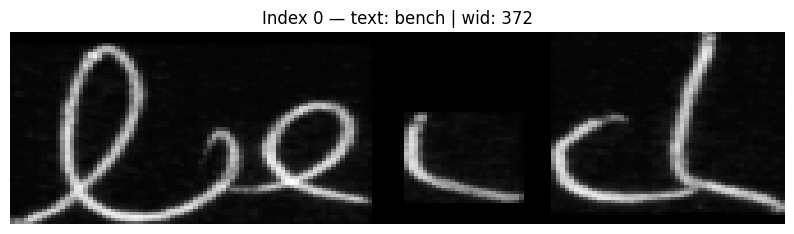

In [9]:
# Example: reconstruct the N-th sample's image and label text from the HDF5 file
def get_sample(path, index=0):
    import h5py
    if not os.path.exists(path):
        print('file not found:', path); return None
    with h5py.File(path, 'r') as f:
        img_seek = int(f['img_seek_idxs'][index])
        img_len = int(f['img_lens'][index])
        lb_seek = int(f['lb_seek_idxs'][index])
        lb_len = int(f['lb_lens'][index])
        # imgs stored as (H, concat_width)
        imgs = f['imgs'][:]
        img = imgs[:, img_seek: img_seek + img_len]
        lbs = f['lbs'][:]
        chars = ''.join(chr(c) for c in lbs[lb_seek: lb_seek + lb_len])
        wid = int(f['wids'][index]) if 'wids' in f else None
        return img, chars, wid

sample = get_sample(h5_path, index=0)
if sample is not None:
    img, text, wid = sample
    print('sample text ->', text)
    print('sample wid ->', wid)
    # display
    plt.figure(figsize=(min(10, img.shape[1] / 10), 2.5))
    plt.imshow(img, cmap='gray', aspect='auto')
    plt.title(f'Index 0 — text: {text} | wid: {wid}')
    plt.axis('off')
    plt.show()

## How collate (collect_fn) prepares batches for the model
- `collect_fn` builds padded tensors for: `org_imgs`, `style_imgs`, optional `aug_imgs`. It pads images to the next multiple of `CharWidth` using -1 as the pad value (so padded areas are negative).
- Labels (`lbs`) are padded with zeros to the max label length in the batch. `lb_lens` stores the true lengths used by sequence losses.
- `wids` are returned as integer tensor (writer ids) and may be used for writer identification/loss if applicable.
- Sorting helpers (`sort_collect_fn_style` / `sort_collect_fn_aug`) sort by style or augmented image lengths to improve RNN packing/efficiency.

Number of word images in file = 11170
image widths: min, median, max = 17 137.0 935
total label characters = 49638


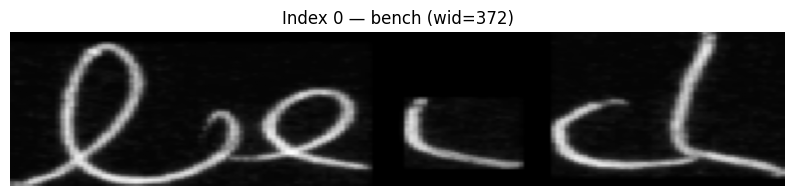

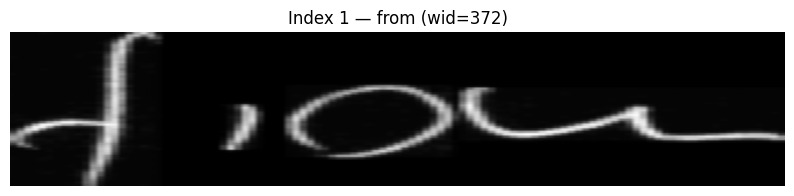

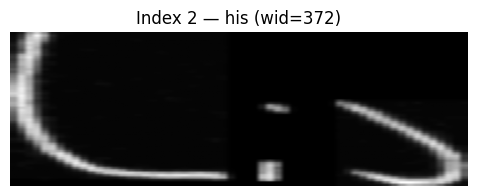

In [10]:
# Quick loop: print basic stats and show 3 examples (if file present)
if os.path.exists(h5_path):
    with h5py.File(h5_path, 'r') as f:
        n = len(f['img_lens'])
        print('Number of word images in file =', n)
        widths = np.array(f['img_lens'])
        print('image widths: min, median, max =', widths.min(), np.median(widths), widths.max())
        try:
            chars_total = len(f['lbs'])
            print('total label characters =', chars_total)
        except Exception:
            pass
    # show first 3 examples
    for i in range(min(3, n)):
        img, text, wid = get_sample(h5_path, i)
        plt.figure(figsize=(min(10, img.shape[1] / 10), 2))
        plt.imshow(img, cmap='gray', aspect='auto')
        plt.title(f'Index {i} — {text} (wid={wid})')
        plt.axis('off')
        plt.show()
else:
    print('HDF5 file not found at', h5_path)
    print('If you are running this notebook locally, ensure the `iam/` folder exists at the repository root or set `h5_path` to the correct absolute path.')

## Edge cases and tips
- The `imgs` array is a memory-efficient concatenation; be careful when loading very large HDF5 files since `imgs[:]` materializes the whole array in memory.
- The code in `Hdf5Dataset` subtracts the minimum from `wids` when `normalize_wid=True` so writer ids start from 0.
- Padding uses `-1` for image tensors and `0` for label tokens — this is important for loss masking.
- If you want to create a custom HDF5 file, use `Hdf5Dataset.gen_h5file(...)` as shown in `lib/datasets.py` to ensure the correct keys and dtypes.

If you'd like, I can also: (a) add a lightweight unit test that opens the HDF5 and asserts expected dtypes/shapes; (b) create a small script to generate a tiny example HDF5 to demonstrate end-to-end creation + read. Tell me which you'd prefer next.